<a href="https://colab.research.google.com/github/emincingoz/Machine_Learning_Collection/blob/scratch/Image_Classification_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
#!curl is an utility for transferring data from ...
!curl https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip -L -o catsanddogs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  77.3M      0  0:00:10  0:00:10 --:--:-- 83.0M


In [12]:
import os

os.chdir('/gdrive/My Drive/CNN/')

!ls

catsanddogs.zip		 gender_classification.ipynb
fashion_MNIST_CNN.ipynb  Image_Classification_from_Scratch.ipynb


In [13]:
!unzip -q catsanddogs.zip
!ls

 catsanddogs.zip			  'MSR-LA - 3467.docx'
 fashion_MNIST_CNN.ipynb		   PetImages
 gender_classification.ipynb		  'readme[1].txt'
 Image_Classification_from_Scratch.ipynb


In [14]:
!ls PetImages

Cat  Dog


## Filter Out Corrupted Images

[Wikipedia](https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format#File_format_structure) explains that JPG files contain the string "JFIF" at the beginning of the file, encoded as bytes

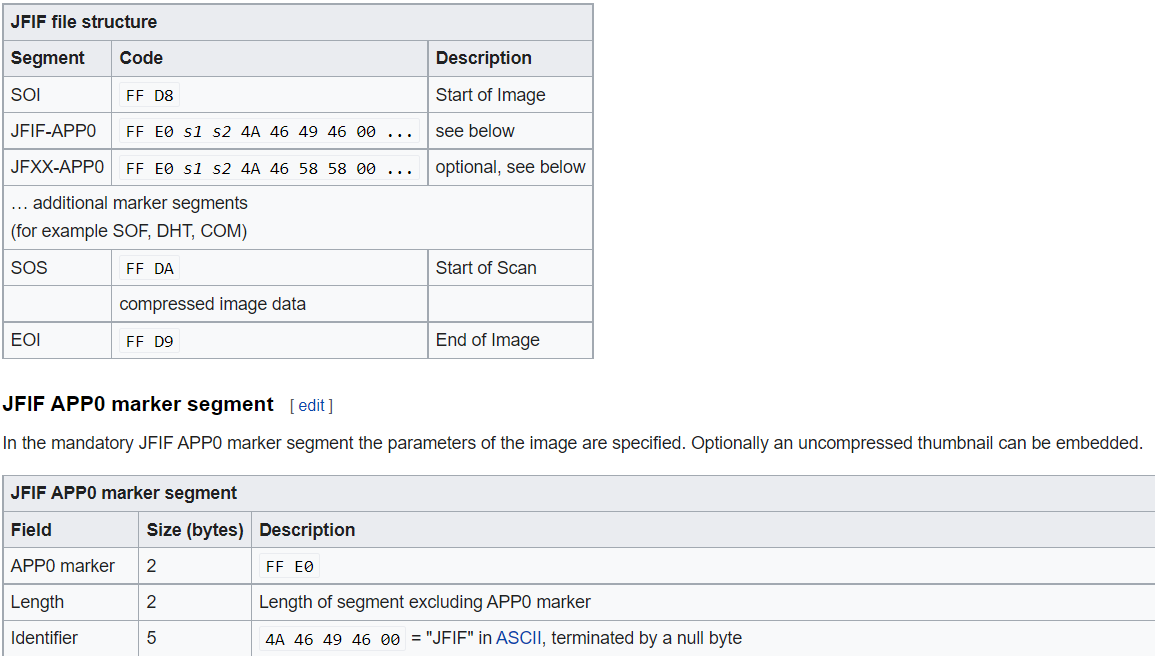

In [15]:
import os

num_skipped = 0
for folder_name in('Cat', 'Dog'):
  # add folder_name to PetImages
  folder_path = os.path.join('PetImages', folder_name)

  # It keeps the files in folder_path as a list
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)

    try:
      # 'rb': Opens the file in binary format for reading
      fobj = open(fpath, 'rb')
      # tf.compat.as_bytes("JFIF") converts the string "JFIF" to bytes.
      # You could also just use b'JFIF'
      # fobj.peek(10) theoretically returns the first 10 bytes of the file
      is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1

      # delete corrupted images
      os.remove(fpath)

print('Deleted %d images' % num_skipped)

Deleted 1561 images


## Generate a Dataset

In [16]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (180, 180)
batch_size = 32

train_ds = image_dataset_from_directory('PetImages', 
                                        validation_split = 0.2, 
                                        subset = 'training', 
                                        seed = 1337, 
                                        image_size = image_size, 
                                        batch_size = batch_size) 

val_ds = image_dataset_from_directory('PetImages', 
                                        validation_split = 0.2, 
                                        subset = 'validation', 
                                        seed = 1337, 
                                        image_size = image_size, 
                                        batch_size = batch_size) 

Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


In [17]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Visualize the Data

* label 1 is 'dog'
* label 0 is 'cat'


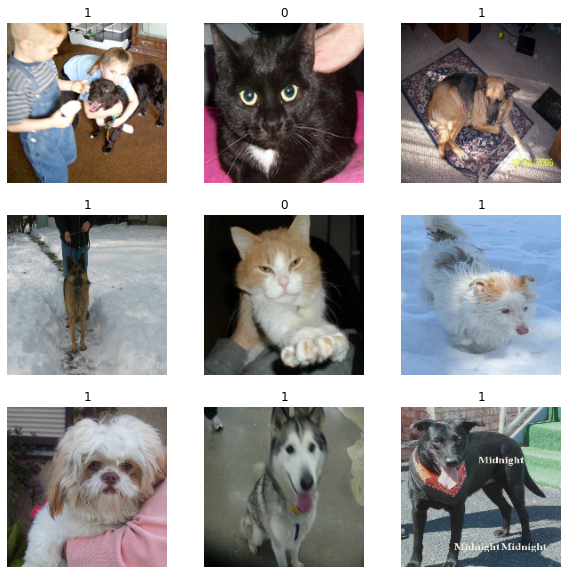

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

## Using Image Data Augmentation

When you don't have a large image dataset, it's a good idea to artificially introduce sample diversity by applying random yet realistic transformations

In [19]:
data_augmentation = keras.Sequential(
    [
          layers.RandomFlip('horizontal'),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.5),
          layers.RandomContrast(0.2),
          layers.RandomTranslation(0.2, 0.2),
    ]
)

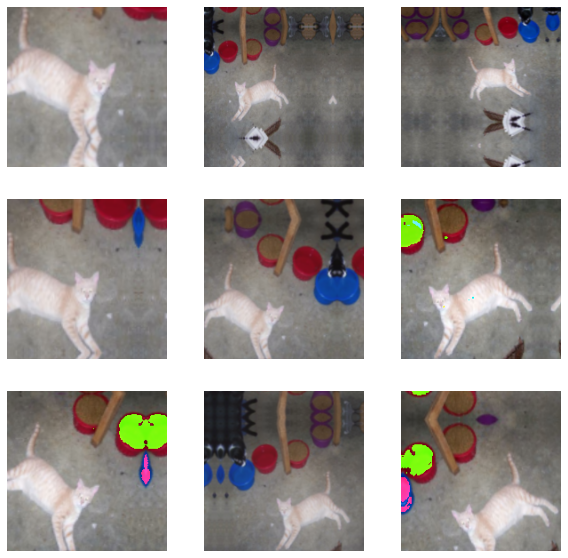

In [20]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

## Standardize the Data

### Option 1

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this is the better option.

In [42]:
input_shape=image_size + (3,)
input_shape

(180, 180, 3)

In [41]:
inputs = keras.Input(shape = input_shape)

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

### Option 2

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the first option.

In [26]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training = True), y))

## Configure the Dataset for Performance

In [43]:
train_ds = train_ds.prefetch(buffer_size = 32)
val_ds = val_ds.prefetch(buffer_size = 32)